In [14]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [15]:
# nltk.download('punkt')
# pip install unidecode


In [16]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_70_30.csv')
data_val = pd.read_csv('../../Data Splits/val_data_70_30.csv')

In [17]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

print(X_train)

0       "Hindi niyo karapatan na alisan kami ng discip...
1       Sapul sa komentaryo ng radio host at pro-gover...
2       Suddenly, marami ang hihingi sa iyo ng iba't i...
3       Kung intention mo to keep a secret, then tumah...
4       Sa interview kay Paolo after the presscon, bin...
                              ...                        
1887    Kaya pala nahinto na sa pagbibilang ng partial...
1888    Nagliyab sa galit si National Capital Region P...
1889    Sa programa ng CNN Philippines para sa mga sen...
1890    Nagposte si Ricky Marcos ng 13 puntos na kinab...
1891    Nahuli na ang suspek sa nangyaring pamamaril n...
Name: article, Length: 1892, dtype: object


In [18]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess(text) for text in X]

    def preprocess(self, text):
        # print(textes)
        text = str(text)
        text = text.lower()
        normalized = unicodedata.normalize("NFD", text)
        text = "".join(c for c in normalized if unicodedata.category(c) != "Mn")
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        return text

In [19]:
#create StopWords
stopwords = pd.read_json('../../Datasets/stopwords-tl.json')
custom_stop_words = stopwords[0].values.tolist()

In [20]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

# Define the parameter grid
param_grid = {
    
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting scheme
    'metric': ['euclidean', 'cosine', 'manhattan', 'minkowski']  # Distance metric
}

In [21]:
# Define the steps in your pipeline
steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer(stop_words=custom_stop_words)),
    ('gridsearch', GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1))

]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['akin', 'aking', 'ako', 'alin',
                                             'am', 'amin', 'aming', 'ang',
                                             'ano', 'anumang', 'apat', 'at',
                                             'atin', 'ating', 'ay', 'bababa',
                                             'bago', 'bakit', 'bawat', 'bilang',
                                             'dahil', 'dalawa', 'dapat', 'din',
                                             'dito', 'doon', 'gagawin',
                                             'gayunman', 'ginagawa', 'ginawa', ...])),
                ('gridsearch',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                              param_grid={'metric': ['euclidean', 'cosine',
                                                     'manhattan', 'minkowski'],
                                          'n_neighbors': [3, 5, 7, 9, 11],
                                          'weights': ['uniform', 'distance']},
                              scoring='accuracy'))])

In [22]:
best_meta = pipeline.named_steps['gridsearch'].best_estimator_
joblib.dump(pipeline.named_steps['gridsearch'].best_estimator_, '../../Models/70-30 Test/pipeline_knn_best_estimator.joblib')


['../../Models/70-30 Test/pipeline_knn_best_estimator.joblib']

In [23]:
print("Best Hyperparameters: ", pipeline.named_steps['gridsearch'].best_params_)
print("Best Accuracy: {:.2f}%".format(pipeline.named_steps['gridsearch'].best_score_ * 100))

Best Hyperparameters:  {'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}
Best Accuracy: 86.47%


In [24]:

steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer(stop_words=custom_stop_words)),
    ('stacking', StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta ,cv=5))
    ]
stack = Pipeline(steps)
stack.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['akin', 'aking', 'ako', 'alin',
                                             'am', 'amin', 'aming', 'ang',
                                             'ano', 'anumang', 'apat', 'at',
                                             'atin', 'ating', 'ay', 'bababa',
                                             'bago', 'bakit', 'bawat', 'bilang',
                                             'dahil', 'dalawa', 'dapat', 'din',
                                             'dito', 'doon', 'gagawin',
                                             'gayunman', 'ginagawa', 'ginawa', ...])),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('MNB', MultinomialNB()),
                                                ('LR', LogisticRegression()),
                                                ('RF',
                                                 RandomForestClassifier()),
                                                ('KNN', KNeighborsClassifier()),
                                                ('SVM', SVC(probability=True))],
                                    final_estimator=KNeighborsClassifier(metric='cosine',
                                                                         weights='distance')))])

In [25]:
print(X_val)

0      High school graduate? No problem! Maaari nang ...
1      Humanga ang netizens sa katapatan na ipinakita...
2      Lumiham noong Huwebes ang DTI sa mga manufactu...
3      Kahapon, ibinunyag ni Pangulong Rodrigo DUtert...
4      Ayon sa ulat ng Commission on Audit (COA), pum...
                             ...                        
807    Binitbit ng mga mandaragat na Espanyol ang mga...
808    Niyanig ng magnitude 4.7 na lindol ang bayan n...
809    Hanggang sa kasalukuyan ay palaisipan pa rin s...
810    IGINIIT  ng Palasyo na sapat ang naging ayuda ...
811    DALAWANG sikat na noontime show host na lalaki...
Name: article, Length: 812, dtype: object


Metrics for MNB:
Accuracy: 0.7980295566502463
Precision: 0.720216606498195
Recall: 0.9779411764705882
F1 Score: 0.8295218295218295
AUC: 0.9653162007377208
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.62      0.75       404
           1       0.72      0.98      0.83       408

    accuracy                           0.80       812
   macro avg       0.84      0.80      0.79       812
weighted avg       0.84      0.80      0.79       812



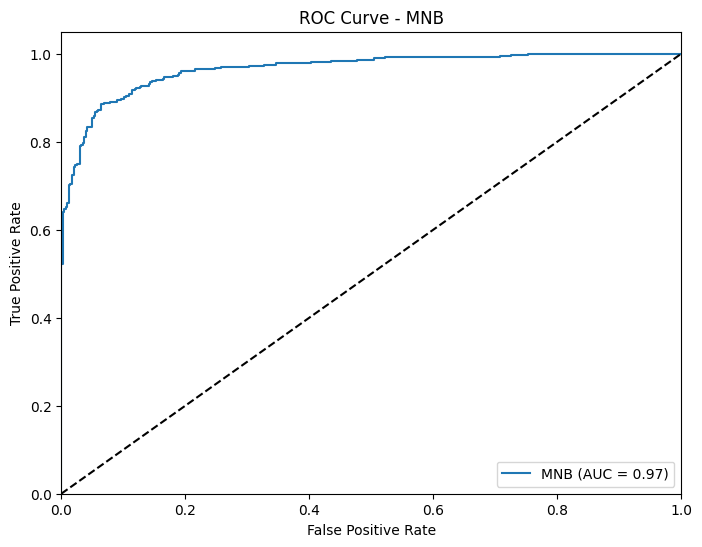

Metrics for LR:
Accuracy: 0.9039408866995073
Precision: 0.9319371727748691
Recall: 0.8725490196078431
F1 Score: 0.9012658227848102
AUC: 0.9754901960784313
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       404
           1       0.93      0.87      0.90       408

    accuracy                           0.90       812
   macro avg       0.91      0.90      0.90       812
weighted avg       0.91      0.90      0.90       812



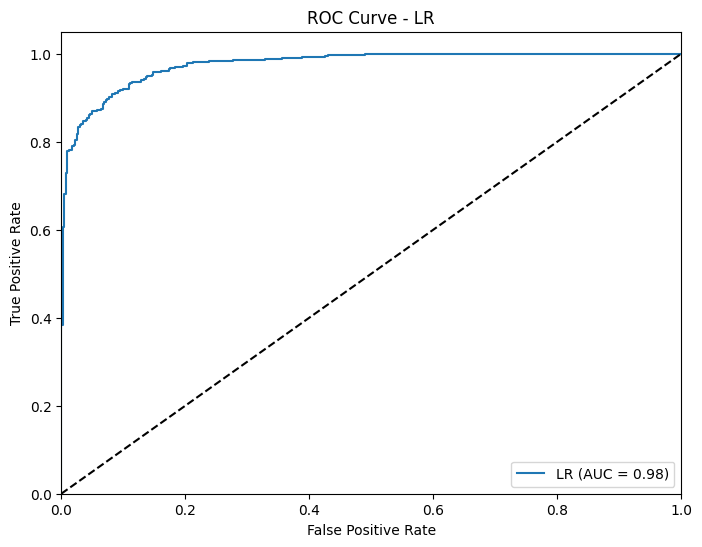

Metrics for RF:
Accuracy: 0.9137931034482759
Precision: 0.916256157635468
Recall: 0.9117647058823529
F1 Score: 0.914004914004914
AUC: 0.9720260629004077
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       404
           1       0.92      0.91      0.91       408

    accuracy                           0.91       812
   macro avg       0.91      0.91      0.91       812
weighted avg       0.91      0.91      0.91       812



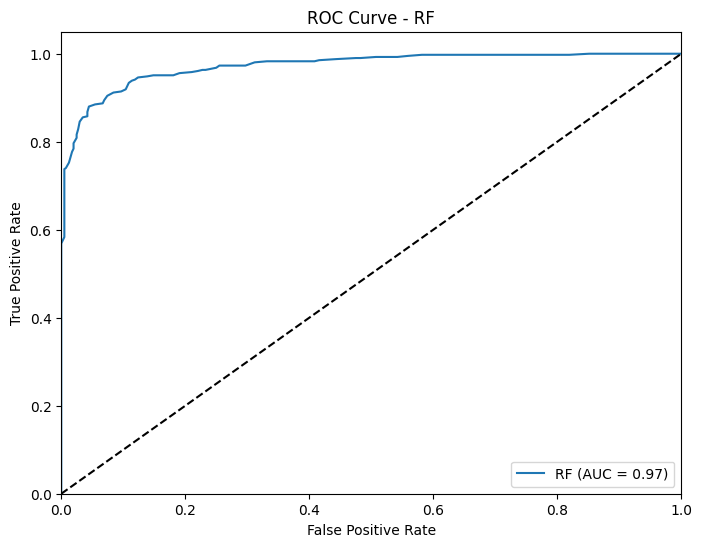

Metrics for KNN:
Accuracy: 0.8448275862068966
Precision: 0.8078602620087336
Recall: 0.9068627450980392
F1 Score: 0.8545034642032333
AUC: 0.9288366336633664
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       404
           1       0.81      0.91      0.85       408

    accuracy                           0.84       812
   macro avg       0.85      0.84      0.84       812
weighted avg       0.85      0.84      0.84       812



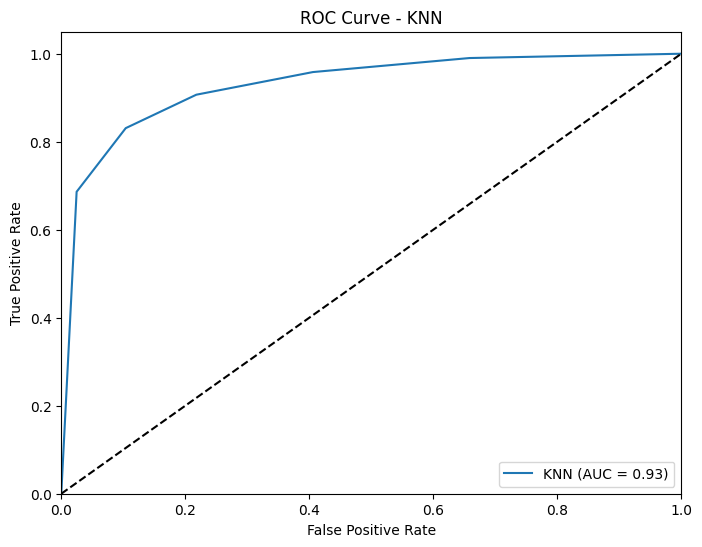

Metrics for SVM:
Accuracy: 0.9211822660098522
Precision: 0.9526315789473684
Recall: 0.8872549019607843
F1 Score: 0.9187817258883249
AUC: 0.983279945641623
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       404
           1       0.95      0.89      0.92       408

    accuracy                           0.92       812
   macro avg       0.92      0.92      0.92       812
weighted avg       0.92      0.92      0.92       812



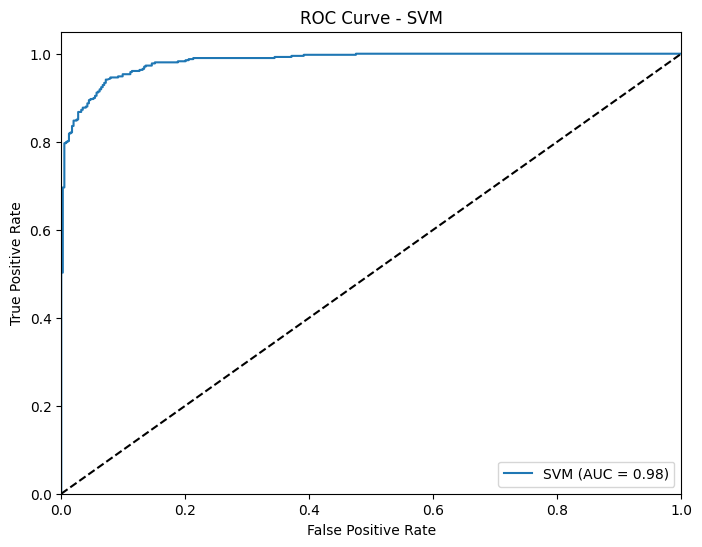

In [26]:


# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Use TFIDF inside of stacking to vectorize X_val(Evaluation)
vectorized_text = stack.named_steps['vectorizer'].transform(X_val)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9396551724137931
Precision: 0.9388753056234719
Recall: 0.9411764705882353
F1 Score: 0.9400244798041616
AUC: 0.9752717918850708
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       404
           1       0.94      0.94      0.94       408

    accuracy                           0.94       812
   macro avg       0.94      0.94      0.94       812
weighted avg       0.94      0.94      0.94       812



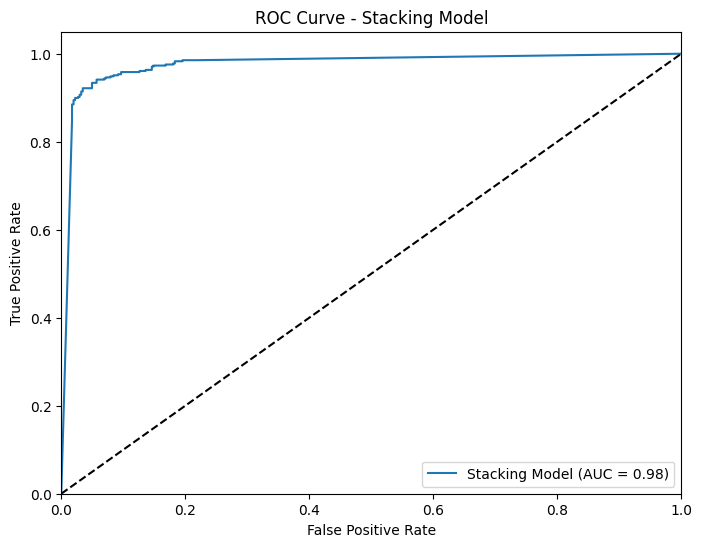

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB              0.79803  0.720217  0.977941  0.829522  0.965316
LR              0.903941  0.931937  0.872549  0.901266   0.97549
RF              0.913793  0.916256  0.911765  0.914005  0.972026
KNN             0.844828   0.80786  0.906863  0.854503  0.928837
SVM             0.921182  0.952632  0.887255  0.918782   0.98328
Stacking Model  0.939655  0.938875  0.941176  0.940024  0.975272


In [27]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val)
stack_y_prob = stack.predict_proba(X_val)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [28]:
# Save the model using joblib
joblib.dump(stack, '../../Models/70-30 Test/pipeline_knn.joblib')

['../../Models/70-30 Test/pipeline_knn.joblib']